In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

11490434/11490434 [==============================] - 0s 0us/step
4 Random Training samples and labels


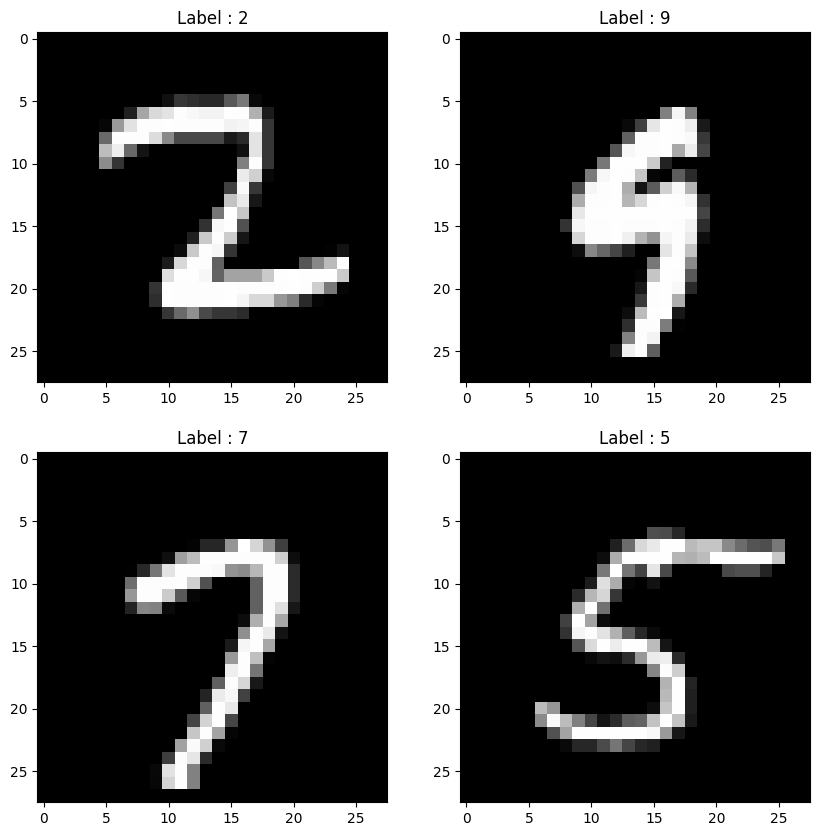

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

In [ ]:
class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )

In [ ]:
class FFNetwork(keras.Model):

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.05),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)


    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}

In [ ]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

In [ ]:
model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 250
history = model.fit(train_dataset, epochs=epochs)

Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 65s 65s/step - FinalLoss: 0.7276
Epoch 2/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6994
Epoch 3/250
1/1 [==============================] - 7s 7s/step - FinalLoss: 0.6754
Epoch 4/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6447
Epoch 5/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6180
Epoch 6/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5958
Epoch 7/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5767
Epoch 8/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5604
Epoch 9/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5463
Epoch 10/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5339
Epoch 11/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.522

Test Accuracy score : 97.68%


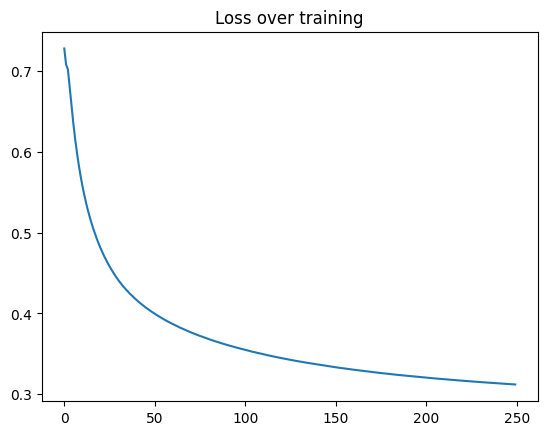

In [ ]:
preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

In [ ]:
X = []
Y = []

In [ ]:
#for learning rate 0.03
#Test accuracy score: 97.68%
#Final Loss: 0.3121
X.append(range(len(history.history["FinalLoss"])))
Y.append(history.history["FinalLoss"])

Test Accuracy score : 97.32%


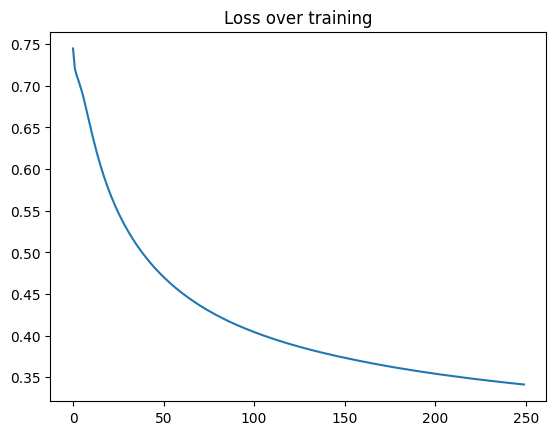

In [ ]:
#for learning rate 0.01
#Test Accuracy Score: 97.32%
#Final Loss: 0.3413

preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

In [ ]:
#for learning rate 0.01
X.append(range(len(history.history["FinalLoss"])))
Y.append(history.history["FinalLoss"])

In [ ]:
len(X)

2

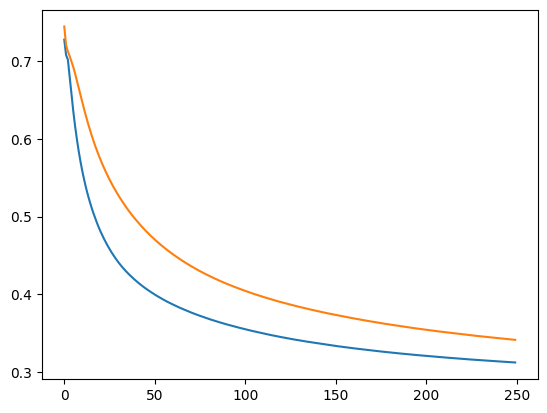

In [ ]:
plt.plot(X[0], Y[0])
plt.plot(X[1], Y[1])
plt.show()

Test Accuracy score : 97.58%


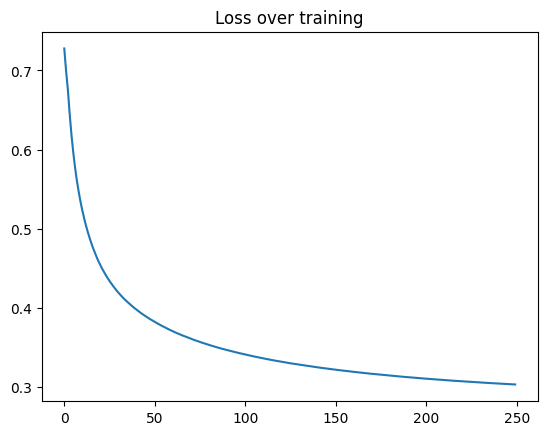

In [ ]:
#for learning rate 0.05
#Test Accuracy Score: 97.58%
#Final Loss: 0.3035

preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

In [ ]:
#for learning rate 0.05
X.append(range(len(history.history["FinalLoss"])))
Y.append(history.history["FinalLoss"])

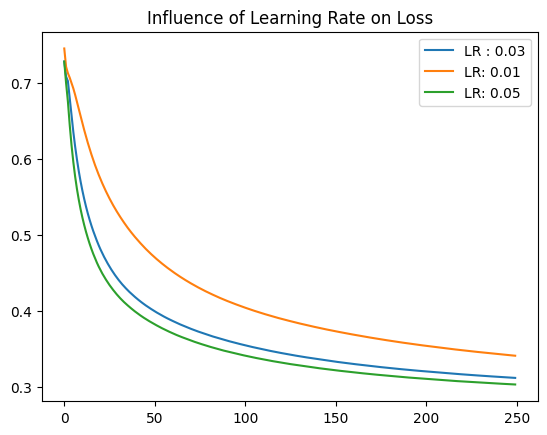

In [ ]:
plt.plot(X[0], Y[0], label = "LR : 0.03")
plt.plot(X[1], Y[1], label = "LR: 0.01")
plt.plot(X[2], Y[2], label = "LR: 0.05")
plt.title("Influence of Learning Rate on Loss")
plt.legend()
plt.show()